# Kmeans cluster

This part will do the Kmean cluster to get which color is most dominant in the picture
Each cluster identified by K-Means becomes a filter. The region under the mask is available to future analysis.
Here this includes gcc, rcc (and bcc) graphs over time for the original images as well as each of the filters.
To do: statistical analysis of the filter outputs to decide if:
1) Filters shoudl be merged because they behave like each other... therefore provide little new information individually.
2) Add tick marks to the xcc graphs to indication the start, mean maximum and end of phenophase for the species at the NEON site. Those species lists are in the NEON site metadata file.
3) The gcc, rcc shoudl be correlated with human phenology observation data to see if changes in rcc or gcc are aligned with phenophase human observations


In [1]:
from skimage.color import rgb2gray, rgb2lab, deltaE_cie76
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time
from scipy import ndimage
from sklearn.cluster import KMeans
from collections import Counter

In [13]:
##################################################################
#Color identification - RGB to Hex Conversion
def RGB2HEX255(color):
    #return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))    
    return "#{:02x}{:02x}{:02x}".format(color[0], color[1], color[2])

##################################################################
#Color identification - RGB to Hex Conversion
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255))

##################################################################
def swap2images(image1, image2):
    WINDOW_NAME = "win"
    """ Display an image with cv2 replace with another image
    for X seconds. can show contrast between 
    """
    cv2.namedWindow(WINDOW_NAME)
    initialtime = time.time()

    cv2.startWindowThread()

    while (time.time() - initialtime < 8):
        cv2.imshow(WINDOW_NAME, image1)
        cv2.waitKey(500)
        cv2.imshow(WINDOW_NAME, image2)
        cv2.waitKey(500)
    #print ("before first waitkey(1)")
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    #print ("before second waitkey(1)")
    cv2.waitKey(1)
    return(1)

##################################################################
def ColorClusterPie(pie_labels, pie_center_colors):
    """
    This function will perform the K mean and display it into to the pie chart
    
    params:
        labels: the list of labels available in the image
    """
    # Count the frequency of each label/color
    label_counts = np.bincount(pie_labels)

    # Create a list of (label, frequency) tuples
    label_freq_pairs = [(label, count) for label, count in enumerate(label_counts)]

    # Sort the list by frequency in descending order
    label_freq_pairs.sort(key=lambda x: x[1], reverse=True)

    # Create a sorted ndarray of Center-colors based on label frequency
    sorted_center_colors = np.array([pie_center_colors[label] for label, _ in label_freq_pairs])

    # Extract the frequencies and labels from the sorted pairs
    frequencies = [freq for _, freq in label_freq_pairs]
    color_labels = [f'Color {i}: {sorted_center_colors[i]}' for i in range(len(label_freq_pairs))]

    # Plot the pie chart
    plt.pie(frequencies, labels=color_labels, colors=sorted_center_colors/255.0, autopct='%1.1f%%')
    plt.axis('equal')  # Equal aspect ratio ensures circular pie
    plt.show()
 
    return sorted_center_colors
    

##################################################################
"""
Given an RGB image, replace one of the colors with an RGB value to be replaced
Plot the result
"""
def replaceAColor (image, target_rgb, replacement_rgb):
    # the images that will have a color replaced
    color_deleted_image = np.uint8(image)

    # Find indices where target_rgb occurs in the image
    indices = np.where(np.all(color_deleted_image == target_rgb, axis=-1))
    #print('indicies.shape {0}',format(indices.shape))
    # Replace the values at the indices with replacement_rgb
    color_deleted_image[indices] = replacement_rgb
    return color_deleted_image

##################################################################
# not working!!! replace a list of different colors with a color
def replaceMultipleColors (image, target_rgb_list, replacement_rgb):
    color_deleted_image = np.uint8(image)
    for target_rgbi in target_rgb_list:
        #print(target_rgbi)
        color_deleted_image = replaceAColor (color_deleted_image, target_rgbi, replacement_rgb)
    return color_deleted_image

##################################################################
def replaceAllButOneColor(image, unchanged_rgb, replacement_rgb):  
     # the images that will have a color replaced
    color_deleted_image = np.uint8(image)

    # Find indices where target_rgb occurs in the image
    indices = np.where(~np.all(color_deleted_image == unchanged_rgb, axis=-1))
    #inverse_indices = np.where(~indices)[0]
    # Replace the values at the indices with replacement_rgb
    color_deleted_image[indices] = replacement_rgb
    return color_deleted_image


####################################################################
import matplotlib.pyplot as plt
def plot_xcc (xcc, title, caption):
    # Extract the magnitudes of rcc, gcc, and bcc from the first column of xcc
    rcc = [data[0][0] for data in xcc]
    gcc = [data[0][1] for data in xcc]
    bcc = [data[0][2] for data in xcc]

    # Create the x-axis values (row numbers)
    x = range(len(xcc))

    # Plot the lines
    plt.plot(x, rcc, color='red', label='rcc')
    plt.plot(x, gcc, color='green', label='gcc')
    plt.plot(x, bcc, color='blue', label='bcc')

    # Set the axis labels and title
    plt.xlabel(caption)
    plt.ylabel('Magnitude')
    plt.title(title)

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()
    return 1

####################################################################
import matplotlib.pyplot as plt
def plot_rcc (rcc, StartFlower, EndFlower, StartLeafBud, EndLeafBud, title, caption):
    # Extract the magnitudes of rcc, gcc, and bcc from the first column of xcc

    # Create the x-axis values (row numbers)
    x = range(len(rcc))

    # Plot the lines
    plt.plot(x, rcc, color='red', label='rcc')
#    plt.plot(x, gcc, color='green', label='gcc')
#    plt.plot(x, bcc, color='blue', label='bcc')
    plt.plot([StartFlower, EndFlower], [rcc[StartFlower], rcc[StartFlower]], color='black', label='Flowering')
    plt.plot([StartLeafBud, EndLeafBud], [rcc[StartLeafBud], rcc[StartLeafBud]], color='green', label='Leaf buds')

    # Set the axis labels and title
    plt.xlabel(caption)
    plt.ylabel('Magnitude')
    plt.title(title)

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()
    return 1

####################################################################
def slow_horizontal_variance(im):
    '''Return average variance of horizontal lines of a grayscale image'''
    #width, height = im.size
    width, height = im.shape
    if not width or not height: return 0
    vars = []
    #pix = im.load()
    pix = im
    for y in range(height):
        row = [pix[x,y] for x in range(width)]
        mean = sum(row)/width
        variance = sum([(x-mean)**2 for x in row])/width
        vars.append(variance)
    return sum(vars)/height

"""
https://harvardforest1.fas.harvard.edu/sites/harvardforest.fas.harvard.edu/files/publications/pdfs/Sonnentag_AgriFarmMag_2011.pdf
A widely used
example to describe canopy greenness is excess green (ExG) defined
as:
2G − (R + B) (2)
Excess green was found to be superior over other color indices for
the distinction between green plants and soil/residue background
by enhancing the signal from green plant material (Woebbecke
et al., 1995).
"""

####################################################################
import numpy as np

def calculate_excess_green(img):
    # Store the original data type
    original_dtype = img.dtype
    
    # Convert image array to float64 data type
    img = img.astype(np.float64)
    
    # Create an empty array to store the ExG values
    exg_img = np.zeros_like(img, dtype=np.float64)
    
    # Iterate through each pixel
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Extract the red, green, and blue values for the current pixel
            R = img[i, j, 0]
            G = img[i, j, 1]
            B = img[i, j, 2]
            
            # Calculate the excess green (ExG) using the formula: 2G - (R + B)
            exg = (2 * G) - (R + B)
            
            # Update the green value of the pixel with the ExG value
            exg_img[i, j, 1] = exg
    
    # Convert the image array back to the original data type
    exg_img = exg_img.astype(original_dtype)
    
    return exg_img

####################################################################
import cv2
import numpy as np

def is_image_mostly_black(gray_image, threshold):
    # Load the image
    
    # Calculate the percentage of black pixels
    total_pixels = gray_image.size
    black_pixels = np.sum(gray_image == 0)
    black_ratio = black_pixels / total_pixels

    # Check if the black ratio is above the threshold
    if black_ratio >= threshold:
        return True
    else:
        return False


####################################################################
# calculate gcc, rcc and bcc for the original image and for the masks of that image
def get_xcc(image_names, 
            clustered_image, 
            labels, 
            ordered_center_color_index,
            hazy_days):
    xcc_over_time = [] # inner list is 0=R, 2=G, 3=B
    DILATE = 1
    NoDILATE = 0
    i = 0
    for image_file in image_names:
        is_missing_day = False
        isBlack = False
        fog = False
        if not image_file.endswith("jpg"):
            is_missing_day = True
        else:
            img = cv2.imread(image_file)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #swap2images(img, clustered_image)
        if is_missing_day:
            xcc_over_time.append([[ np.nan, np.nan, np.nan], fog, is_missing_day, -1])
        elif is_image_mostly_black(gray, .9) == True or image_file in hazy_days:
            fog = True
            xcc_over_time.append([[ np.nan, np.nan, np.nan], fog, is_missing_day, -1])
            isblack = True
        else:
            # var = slow_horizontal_variance(gray)
            # fog = var > 3000    # FOG THRESHOLD
            print ("Processing: ", image_file, end='\r')
            red = np.sum(img[:,:,0])
            green = np.sum(img[:,:,1])
            blue = np.sum(img[:,:,2])
            colorsum = green + blue + red
            # cluster num is -1 for the original
            xcc_over_time.append([[red/colorsum, green/colorsum, blue/colorsum], fog, is_missing_day, -1])
        
        # for the number of clusters
        for current_cluster in ordered_center_color_index:
            if isBlack or is_missing_day:
                xcc_over_time.append([[ np.nan, np.nan, np.nan], fog, is_missing_day, current_cluster])
            else:
                masked_image = color_mask_image (clustered_image, 
                                  labels, 
                                  current_cluster, 
                                  img, DILATE)
                masked_image_array = np.uint8(masked_image)
                red = np.sum(masked_image[:,:,0])
                green = np.sum(masked_image[:,:,1])
                blue = np.sum(masked_image[:,:,2])
                colorsum = green + blue + red
                xcc_over_time.append([[red/colorsum, green/colorsum, blue/colorsum], fog, is_missing_day, current_cluster])

        i = i+1    
    return xcc_over_time

# use the "fog" flag to signal a data point that should be replaced with interpolation
# Function to interpolate values
# Helper function to interpolate values
####################################################################
def interpolate_values(a, b, ratio):
    return [x + ratio * (y - x) for x, y in zip(a, b)]

####################################################################
def interpolate_bad_values_xcc (data):
    previous_good_index = None
    for i in range(len(data)):
        if data[i][1] or data[i][2]:  # If the row has bad data
            # Find the index of the next good data row
            next_good_index = next((j for j in range(i + 1, len(data)) if not data[j][1] and not data[j][2]), None)
            #print (i, "next good data index", next_good_index)
            if i == 0: # the first element was bad
                data[0][0] = data[next_good_index][0]
                previous_good_index = 0
                #print ("First row bad data replaced with next_good_index: ", next_good_index)
            elif next_good_index is None:
                # If no good data row is found until the end, replace with the first column of the last good data
                #print (i, "next good data is none. Last good index: ", previous_good_index)
                if previous_good_index is not None:
                   # print("previous_good_index: ", previous_good_index)
                    data[i][0] = data[previous_good_index][0]
            else:
                # If a good data row is found before the end, replace with the mean of first columns
                mean_data = [(a + b) / 2 for a, b in zip(data[previous_good_index][0], data[next_good_index][0])]
                data[i][0] = mean_data
                #print("i mean data =",i , mean_data, "last good data", previous_good_index)

        elif previous_good_index is None:
            # If the row has good data, update previous_good_index
            previous_good_index = i
        else: # this row is good data
            #print(i, " good data")
            previous_good_index = i

    return data

# Creat a mask from one of the cluster color image, 
#    labels = each pixel is given the index of it's color class, 
#    color_index_list = the index numbers of the color categories to be used in the mask from KMeans a list of cluster indexes.
#    target_image = a new image to be masked
# return the modified image with all image not in the masked area set to 0.
# Set pixels outside the despeckled mask to zero (black)

####################################################################
def color_mask_image (clustered_image, labels, desired_clusters_list, target_image, dilate):
    # reshape on the x and y axis to list
    labels_reshaped = np.reshape(labels, (clustered_image.shape[0], clustered_image.shape[1]))

    # Construct the mask by changing any labels not in the desired list to FALSE
    mask = np.isin(labels_reshaped, desired_clusters_list)

    if dilate == 1:
        # erosion eliminated much of the picture because the areas are so fragmented
        # Define the structuring element for dilation
        kernel = np.ones((3, 3), np.uint8)  # Adjust the kernel size based on desired expansion
        # Perform erosion to decrease cluster size
        #eroded_mask = cv2.erode(mask, kernel, iterations=1)
        #mask = eroded_mask

        # Perform dilation to increase cluster size
        dilated_mask = dilate_mask(mask, iterations=1)
        mask = dilated_mask
    
    # Apply the mask to the second image
    result = target_image.copy()
    result[~mask] = 0  # Set pixels outside the mask to zero (black)

    # Apply the mask to the second image
    #return im.fromarray(result)
    return result


####################################################################
from scipy.ndimage import binary_dilation
def dilate_mask(mask, iterations=1):
    dilated_mask = binary_dilation(mask, iterations=iterations)
    return dilated_mask



####################################################################
def subtract_xcc (xcc, xcc2):
# Assuming xcc and xcc2 have the same length
    result = []

    for data1, data2 in zip(xcc, xcc2):
        # Subtract corresponding elements
        subtracted_data = [
            data1[0][0] - data2[0][0],
            data1[0][1] - data2[0][1],
            data1[0][2] - data2[0][2]
        ]

        # Preserve the other columns
        result.append([subtracted_data, data1[1], data1[2]])
    return result

####################################################################
#Calculate a running median with a window of 5 to smooth the curves.
import statistics
def xcc_median5_smooth(xcc):
# this should be generalized for any mrcdian window.
    window_size = 5
    new_first_column = []

    for i in range(len(xcc)):
        if i == 0:
            # Calculate the median for the first two rows
            median_1 = statistics.median([data[0][0] for data in xcc[:i+5]])
            #print("i, median_1, xcc[:1+5]", i, median_1, xcc[:1+5])
            median_2 = statistics.median([data[0][1] for data in xcc[:i+5]])
            median_3 = statistics.median([data[0][2] for data in xcc[:i+5]])
        elif i == 1:
            # Calculate the median for the first two rows
            median_1 = statistics.median([data[0][0] for data in xcc[:i+4]])
            median_2 = statistics.median([data[0][1] for data in xcc[:i+4]])
            median_3 = statistics.median([data[0][2] for data in xcc[:i+4]])
        elif i == len(xcc) - 2:
            # Calculate the median for the last two rows
            median_1 = statistics.median([data[0][0] for data in xcc[i-3:]])
            median_2 = statistics.median([data[0][1] for data in xcc[i-3:]])
            median_3 = statistics.median([data[0][2] for data in xcc[i-3:]])
        elif i == len(xcc) - 1:
            # Calculate the median for the last two rows
            median_1 = statistics.median([data[0][0] for data in xcc[i-4:]])
            median_2 = statistics.median([data[0][1] for data in xcc[i-4:]])
            median_3 = statistics.median([data[0][2] for data in xcc[i-4:]])
        else:
            # Calculate the median for the window of five rows
            median_1 = statistics.median([data[0][0] for data in xcc[i-2:i+2]])
            median_2 = statistics.median([data[0][1] for data in xcc[i-2:i+2]])
            median_3 = statistics.median([data[0][2] for data in xcc[i-2:i+2]])
            
        new_first_column.append([[median_1, median_2, median_3], xcc[i][1], xcc[i][2]])
        
    return new_first_column



####################################################################
from datetime import date, timedelta
# get all date between [start_date, end_date]
def get_all_days_in_range(start_date, end_date):
    delta = end_date - start_date   # returns timedelta
    all_days = []
    for i in range(delta.days + 1):
        day = start_date + timedelta(days=i)
        all_days.append(str(day).replace('-', '_'))
    return all_days

####################################################################
# get all date in the year
def get_all_days_in_month(month, year):
    next_month = month + 1 if month < 12 else 1
    next_year = year if month < 12 else year+1
    all_days =  get_all_days_in_range(date(year, month, 1), date(next_year, next_month, 1))
    all_days.pop()

    return set(all_days)

####################################################################
def append_file_prefix_for_missing_day(missing_days, site, year, month):
    return [f'../data_raw/{site}/{year}/{month}/{site}_{missing_day}' for missing_day in missing_days]

####################################################################
# find missing day in a year based on sorted days
def find_missing_day_in_year(sortedDays, year):
    missing_date = []
    day_index = 0
    all_day_in_year = get_all_days_in_year(YEAR)
    for img_file in img_files:
        while day_index < len(all_day_in_year) - 1 and all_day_in_year[day_index] not in img_file:
            missing_date.append(all_day_in_year[day_index])
            day_index += 1
        day_index += 1
    return missing_date

####################################################################
def find_day_in_filename(filename):
    if filename.endswith("jpg"):
        return filename[-21:-11]

####################################################################
import csv
def get_hazy_days(sitename, year):
    hazy_days = []
    hazy_days_file = f'../data_out/foggy/{sitename}/{year}.csv'
    with open(hazy_days_file, mode='r') as csvfile:
        reader = csv.DictReader(csvfile)
        for line in reader:
            hazy_days.append(f'../data_raw/{line["file"]}')
    return hazy_days
    
# hazy_days = get_hazy_days("NEON.D01.BART.DP1.00033", 2018)
# print(hazy_days)

####################################################################
def readimg():
    """
        This function will read and show the image and also return it
    """
    image = plt.imread('../data_raw/NEON.D01.HARV.DP1.00033/2017/01/NEON.D01.HARV.DP1.00033_2017_01_31_120006.jpg')
#    image = plt.imread('../data_raw/Red,_green_and_blue,_overlapping_basic_colors.jpg')
    plt.figure(figsize = (10, 8))
    plt.imshow(image)
    return image

####################################################################
def readanddisplayimg(ImgFilename):
    """
        This function will read and show the image and also return it
    """
    image = plt.imread(ImgFilename)
#    image = plt.imread('../data_raw/Red,_green_and_blue,_overlapping_basic_colors.jpg')
    plt.figure(figsize = (10, 8))
    plt.imshow(image)
    return image


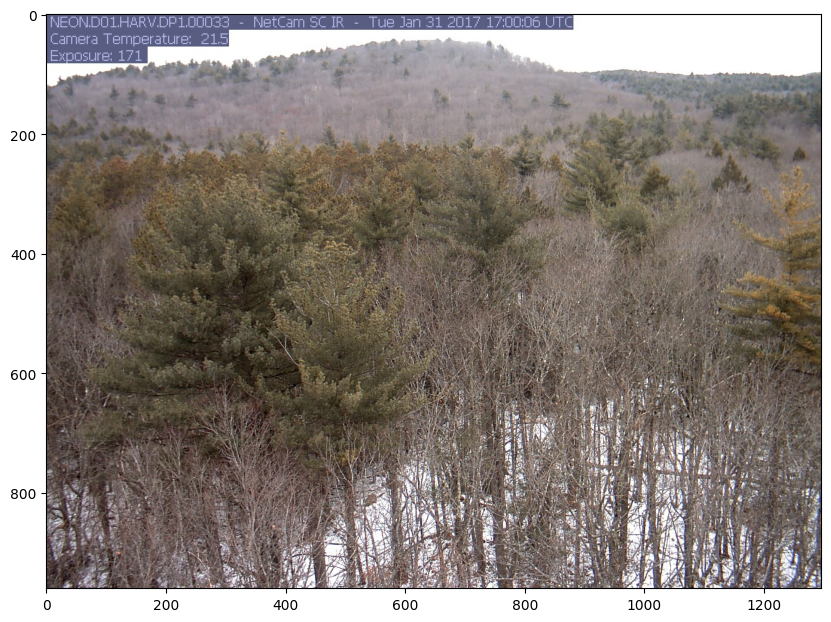

In [15]:
# K-means clustering
from PIL import Image as im

#pic_array = readimg()
pic_array = readanddisplayimg('../data_raw/NEON.D01.HARV.DP1.00033/2017/01/NEON.D01.HARV.DP1.00033_2017_01_31_120006.jpg')
img_array = pic_array
# tried excess green calculation but it did not help.
# excess_green_img = calculate_excess_green(img_array)
# plt.figure(figsize = (10, 8))
# plt.imshow(excess_green_img)
#img_array = excess_green_img

# Reshape the array to a 2D array of pixels (rows) by color channels (columns)
OneDpixelsbycolor = img_array.reshape(-1, 3)

# Set the number of clusters
n_clusters = 8

# Perform K-means clustering on the pixel data
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(OneDpixelsbycolor)
fit_model = kmeans.fit(OneDpixelsbycolor)
# Replace each pixel's color values with the corresponding cluster center
new_pixel_colors = np.array([kmeans.cluster_centers_[label] for label in kmeans.labels_])

# Reshape the pixel array back into the original image shape
Kmean_clustered_img = new_pixel_colors.reshape(img_array.shape)

#swap2images(pic_array, np.uint8(Kmean_clustered_img))

# Convert the pixel array back to an image
clustered_img = im.fromarray(np.uint8(Kmean_clustered_img))

# Save the new image
clustered_img.save("example_clustered.jpg")



In [ ]:
"""
This module will present a pie chart of the relative frequency of pixels of the center colors 
of the kmeans clusters.
"""
center_colors = np.uint8(kmeans.cluster_centers_)

# Get the labels of the K-means clusters
labels = kmeans.labels_

# Reduce to a 2D array.. just a list of tuples
twoDuint_img_array = np.uint8(Kmean_clustered_img.reshape(-1,3))
# swap2images(pic_array, np.uint8(Kmean_clustered_img))

# Get the frequencies of the center colors
unique_colors, color_counts = np.unique(twoDuint_img_array, axis=0, return_counts=True)

rgb_ordered_colors = ColorClusterPie(labels, center_colors)
# Create an array of indices indicating the matching color in color_centers
ordered_center_color_index = indices = np.where(np.all(center_colors == rgb_ordered_colors[:, np.newaxis], axis=-1))[1]


In [ ]:
"""
#Turn the snow and sky black
color_replaced_snow = replaceAColor (Kmean_clustered_img, 
                                       rgb_ordered_colors[6], 
                                       np.array([10, 10, 10], dtype=np.uint8))

color_replaced_image = replaceAColor (color_replaced_snow, 
                                       rgb_ordered_colors[7], 
                                       np.array([10, 10, 10], dtype=np.uint8))
plt.figure(figsize = (10, 8))
plt.imshow(color_replaced_image)
#swap2images(pic_array, color_replaced_image)
"""

In [ ]:
"""
color_replaced_imageExcept0 = replaceAllButOneColor(Kmean_clustered_img, 
                       rgb_ordered_colors[0], 
                       np.array([254, 254, 254], dtype=np.uint8))
plt.figure(figsize = (10, 8))
plt.imshow(color_replaced_imageExcept0)    
"""

In [ ]:
"""
color_replaced_imageExcept1 = replaceAllButOneColor(Kmean_clustered_img, 
                       rgb_ordered_colors[6], 
                       np.array([0, 0, 0], dtype=np.uint8))
plt.figure(figsize = (10, 8))
plt.imshow(color_replaced_imageExcept1)  
color_replaced_image2 = replaceAColor (Kmean_clustered_img, rgb_ordered_colors[2], np.array([254, 254, 254], dtype=np.uint8))
"""


“markdownCellConfig”:{“fontSize”: 20}}
Calculate which masks help, hurt or do nothing to the gcc calculations median 
during greenup.

Calculate the color shifts for each color segment for RCC, GCC and synthedtic colors... maybe merge 3-7 images, clluster, advance in time a day and repeate. calulate nearest neighbor colors in color space to maintain identifty.

1) Read in the images
2) Calculate GCC using Linh moving median for 30? days = GCCBaseline
3) For each cluster
    Apply the mask of cluster to the image
    Recalculate GCC moving median
    Calculate and save the mean difference between GCCBaseline and the masked image
4) Sort all differenceGCC. Make a supermask of all that help GCC
5) Rerun difference in BaselineGcc to the polymasked


? gcc, rcc and bcc normalize brightness. When we start using other colors we'll also need to normalize for brightness. It might be as easy as recalculating gcc, rcc and bcc for each pixel and replacing the original RGB with the normalized values. Or do a regression line of total brightness as spring advnaces. adjust color lines appropriatly... prevent algorithm from learning that the sun gets higher in the sky in summer.
    


In [ ]:

# get all image file names
# this needs to be extended to add many years and months
RED = 0
GREEN = 1
BLUE = 2
image_names = []
hsv_images = []
all_hazy_days = []
years = ["2017"]
months = ["01" , "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
NEONsite = ["NEON.D01.HARV.DP1.00033"]
relative_path = "../data_raw/"
import os
for site in NEONsite:
    for year in years:
        hazy_days = get_hazy_days(site, year)
        all_hazy_days.extend(hazy_days)
        for month in months:
            all_days_in_month = get_all_days_in_month(int(month), int(year))
            filepath = os.path.join("../data_raw/", site, year, month, "")
            for file in os.listdir(filepath):
                if file.endswith(".jpg"):
                    file_date = find_day_in_filename(file)
                    all_days_in_month.remove(file_date)
                    image_names.append(os.path.join(filepath, file))
            image_names.extend(append_file_prefix_for_missing_day(all_days_in_month, site, year, month))
image_names.sort()

In [ ]:

print(f'missing days: {[img for img in image_names if not img.endswith(".jpg")]}\n\n')
print(f'hazy days: {all_hazy_days}')

In [ ]:

xcc_over_time = get_xcc(image_names, Kmean_clustered_img, 
                        labels, ordered_center_color_index, all_hazy_days)
xcc_original = [item for item in xcc_over_time if item[-1] == -1]
xcc_original_data = [item[0] for item in xcc_original]
interpolated_xcc_original = interpolate_bad_values_xcc (xcc_original)

xcc_cluster = []
interpolated_xcc_cluster = []
for current_cluster in range (0, n_clusters):
    ordered_center_color_index[current_cluster]
    xcc_cluster.append([item for item in xcc_over_time if item[-1] == current_cluster])
    interpolated_xcc_cluster.append(interpolate_bad_values_xcc (xcc_cluster[current_cluster]))

# Save the xcc list to a file
import pickle
 
with open("".join(["../data_raw/", NEONsite[0], years[0], "xcc_over_time.pkl"]), 'wb') as file:
    pickle.dump(xcc_over_time, file)

In [ ]:
missing = [x for x in xcc_original if x[2]]
print(len(missing))

In [ ]:
# save the xcc data in binary and csv formats. 
# Construct the file name from the location + first year + last year + first month + last month

xcc_file_name_body = f"{relative_path}{NEONsite[0]}_xcc{years[0]}_{years[-1]}_{months[0]}_{months[-1]}"
xcc_file_name_pkl = f"{xcc_file_name_body}.pkl"
xcc_file_name_csv = f"{xcc_file_name_body}.csv"

import csv
# Save xcc to a CSV file
with open(xcc_file_name_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    for row in xcc_over_time:
        writer.writerow(row)

import pickle
# Save xcc to a binary file
with open(xcc_file_name_pkl, 'wb') as file:
    pickle.dump(xcc_over_time, file)


In [ ]:
# this code would read the data back in... it is not needed in this module.
# this is just for later use.
xcc_file_name_body = f"{relative_path}{NEONsite[0]}_xcc{years[0]}_{years[-1]}_{months[0]}_{months[-1]}"
xcc_file_name_pkl = f"{xcc_file_name_body}.pkl"
# Specify the CSV file path and name
xcc_file_name_csv = f"{xcc_file_name_body}.csv"

import csv
# Load xcc from the CSV file
xcc = []
with open(xcc_file_name_csv, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        xcc_over_time.append([float(value) for value in row])

# xcc is now restored with the data from the CSV file
# Load xcc from the file
import pickle
with open(xcc_file_name_pkl, 'rb') as file:
    xcc_over_time = pickle.load(file)

# xcc is now restored with the saved data structure

In [ ]:

xcc_caption = str(years[0]) + "-" + years[-1] + " Day Number (some days may be skipped)"
smoothed_xcc_original = xcc_median5_smooth(interpolated_xcc_original)
plt.figure(figsize = (10, 8))
plot_xcc(xcc_median5_smooth(interpolated_xcc_original), "Full Image rcc, gcc, bcc", xcc_caption)
summer_image = plt.imread('../data_raw/NEON.D01.HARV.DP1.00033/2017/06/NEON.D01.HARV.DP1.00033_2017_06_30_120006.jpg')

DILATE = 1
# for current_cluster in range (0, n_clusters):
for current_cluster in ordered_center_color_index:
    masked_image = color_mask_image (Kmean_clustered_img, 
                        labels, 
                        [current_cluster], 
                        summer_image, DILATE)
    xcc_title = "Filter#" + str(current_cluster) +  " Magnitude of rcc, gcc, and bcc"
    plt.figure(figsize = (10, 8))
    plot_xcc(xcc_median5_smooth(interpolated_xcc_cluster[current_cluster]), xcc_title, xcc_caption)
    plt.imshow(masked_image)



In [ ]:
plt.imshow(masked_image)
#del selected_rows
#del PhenoEndDOY
#del PhenoEndDate
#del PhenoStartDate

In [ ]:
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# This module reads USA-NPN Site phenometrics files for a given year and extracts the names
# of tree species that were observed that year.
# Colors are assigned to each species based on a prior color list.

# Read the CSV file into a Pandas DataFrame
NPNFile = "../data_raw/NPNNEON.D01.HARV.DP1.000332017-2023datasheet_1685753626088/site_phenometrics_dataHARV2017-2023.csv"
NPNdf = pd.read_csv(NPNFile)

# Create a dictionary to store the unique species_IDs along with their paired Common_Names
filtered_data = NPNdf[NPNdf['Mean_First_Yes_Year'] == 2017]

species_dict = {}

# Iterate through the DataFrame to populate the dictionary
for index, row in filtered_data.iterrows():
    species_id = row['Species_ID']
    common_name = row['Common_Name']
    species_dict[species_id] = common_name
unique_species_list = list(species_dict.items())
cmap = cm.get_cmap('tab10') # Use a color map for getting colors
SpeciesList = [] # Create a new list with the merged colors

for i, (species_id, species_name) in enumerate(unique_species_list):
    # Get the color from the color map based on the index 'i'
    color = cmap(i)
    SpeciesList.append((species_id, species_name, color))
#print (SpeciesList)

# Merge PhenophaseList and linestyles into one two-dimensional list
# Phenophase codes of interest
phenophase_dict = {}

# Iterate through the DataFrame to populate the dictionary
for index, row in filtered_data.iterrows():
    phenophase_id = row['Phenophase_ID']
    phenophase_description = row['Phenophase_Description']
    phenophase_dict[phenophase_id] = phenophase_description
unique_phenophase_list = list(phenophase_dict.items())

'''
linestyles = [
    #(lines style, thickness)
    ("solid", 1),
    (0, (3, 1, 1, 1, 1, 1), 1),  # Densely DashDotted
    ("dotted", 1),
    ("dashdot", 1),
    ((0, (1, 1)), 1),  # Loosely dotted
    ("dashed", 1)
    ("solid", 3),
    (0, (3, 1, 1, 1, 1, 1), 3),  # Densely DashDotted
    ("dotted", 3),
    ("dashdot", 3),
    ((0, (1, 1)), 3),  # Loosely dotted
    ("dashed")
]
'''
linestyle_tuple = [
    ('solid',        (0, ()),              1),
    ('loosely dotted',        (0, (1, 10)),  1),
    ('dotted',                (0, (1, 1)),   1),
    ('densely dotted',        (0, (1, .5)),  1),
    ('long dash with offset', (5, (10, 3)),  1),
    ('loosely dashed',        (0, (5, 10)),  1),
    ('dashed',                (0, (4, 3)),   1),
    ('densely dashed',        (0, (5, 1)),   1),
    ('loosely dashdotted',    (0, (3, 10, 1, 10)), 1),
    ('dashdotted',            (0, (3, 5, 1, 5)),    1),
    ('densely dashdotted',    (0, (3, 1, 1, 1)),    1),
    ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5)), 1),
    ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10)), 1),
    ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)), 1),
    ('thick solid',        (0, ()),              3),
    ('thick loosely dotted',        (0, (1, 10)),  3),
    ('thick dotted',                (0, (1, 1)),   3),
    ('thick densely dotted',        (0, (1, .5)),  3),
    ('thick long dash with offset', (5, (10, 3)),  3),
    ('thick loosely dashed',        (0, (5, 10)),  3),
    ('thick dashed',                (0, (4, 3)),   3),
    ('thick densely dashed',        (0, (5, 1)),   3),
    ('thick loosely dashdotted',    (0, (3, 10, 1, 10)), 3),
    ('thick dashdotted',            (0, (3, 5, 1, 5)),    3),
    ('thick densely dashdotted',    (0, (3, 1, 1, 1)),    3),
    ('thick dashdotdotted',         (0, (3, 5, 1, 5, 1, 5)), 3),
    ('thick loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10)), 3),
    ('thick densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)), 3)
]
# Convert the list of tuples to a list of dictionaries with line styles as keys
linestyles = [{ 'linestyle': style, 'dash_pattern': dash, 'linewidth': width } 
              for style, dash, width in linestyle_tuple]

PhenophaseList = [] # Create a new list with the merged colors
for i, (phenophase_id, phenophase_description) in enumerate(unique_phenophase_list):
    # Get the linestyle and thickness from the color map based on the index 'i'
    #linestyle = linestyles(i)
    linestyle = linestyles[i]['linestyle']
    dash_pattern = linestyles[i]['dash_pattern']
    linewidth = linestyles[i]['linewidth']
    PhenophaseList.append((species_id, phenophase_description, linestyle, linewidth))
#    plt.plot(x, y, lines

In [ ]:
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_xcc_vs_human_data(xcc_values, color_channel):
    """
    plot the xcc vs human data chart
    arg:
        xcc_values: the xcc overtime for the interested site and timeframe
        color_channel: gcc or rcc or bcc
    """
    # This module reads USA-NPN Site phenometrics files for a given year and extracts the names
    # of tree species that were observed that year.
    # Colors are assigned to each species based on a prior color list.

    # Read the CSV file into a Pandas DataFrame
    NPNFile = '../data_raw/NPNNEON.D01.HARV.DP1.000332017-2023datasheet_1685753626088/site_phenometrics_dataHARV2017-2023.csv'
    NPNdf = pd.read_csv(NPNFile)

    # Create a dictionary to store the unique species_IDs along with their paired Common_Names
    filtered_data = NPNdf[NPNdf['Mean_First_Yes_Year'] == 2017]

    species_dict = {}

    # Iterate through the DataFrame to populate the dictionary
    for index, row in filtered_data.iterrows():
        species_id = row['Species_ID']
        common_name = row['Common_Name']
        species_dict[species_id] = common_name
    unique_species_list = list(species_dict.items())
    cmap = cm.get_cmap('tab10') # Use a color map for getting colors
    SpeciesList = [] # Create a new list with the merged colors

    for i, (species_id, species_name) in enumerate(unique_species_list):
        # Get the color from the color map based on the index 'i'
        color = cmap(i)
        SpeciesList.append((species_id, species_name, color))
    #print (SpeciesList)

    # Merge PhenophaseList and linestyles into one two-dimensional list
    # Phenophase codes of interest
    phenophase_dict = {}

    # Iterate through the DataFrame to populate the dictionary
    for index, row in filtered_data.iterrows():
        phenophase_id = row['Phenophase_ID']
        phenophase_description = row['Phenophase_Description']
        phenophase_dict[phenophase_id] = phenophase_description
    unique_phenophase_list = list(phenophase_dict.items())


    linestyle_tuple = [
        ('solid',        (0, ()),              1),
        ('loosely dotted',        (0, (1, 5)),  1),
        ('dotted',                (0, (1, 2)),   1),
        ('densely dotted',        (0, (1, .5)),  1),
        ('long dash with offset', (2.5, (10, 3)),  1),
        ('loosely dashed',        (0, (5, 10)),  1),
        ('dashed',                (0, (4, 3)),   1),
        ('densely dashed',        (0, (5, 1)),   1),
        ('loosely dashdotted',    (0, (3, 10, 1, 10)), 1),
        ('dashdotted',            (0, (3, 5, 1, 5)),    1),
        ('densely dashdotted',    (0, (3, 1, 1, 1)),    1),
        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5)), 1),
        ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10)), 1),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)), 1),
        ('thick solid',        (0, ()),              3),
        ('thick loosely dotted',        (0, (1, 10)),  3),
        ('thick dotted',                (0, (1, 1)),   3),
        ('thick densely dotted',        (0, (1, .5)),  3),
        ('thick long dash with offset', (5, (10, 3)),  3),
        ('thick loosely dashed',        (0, (5, 10)),  3),
        ('thick dashed',                (0, (4, 3)),   3),
        ('thick densely dashed',        (0, (5, 1)),   3),
        ('thick loosely dashdotted',    (0, (3, 10, 1, 10)), 3),
        ('thick dashdotted',            (0, (3, 5, 1, 5)),    3),
        ('thick densely dashdotted',    (0, (3, 1, 1, 1)),    3),
        ('thick dashdotdotted',         (0, (3, 5, 1, 5, 1, 5)), 3),
        ('thick loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10)), 3),
        ('thick densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)), 3)
    ]
    # Convert the list of tuples to a list of dictionaries with line styles as keys
    linestyles = [{ 'linestyle': style, 'dash_pattern': dash, 'linewidth': width } 
                for style, dash, width in linestyle_tuple]

    PhenophaseList = [] # Create a new list with the merged colors
    for i, (phenophase_id, phenophase_description) in enumerate(unique_phenophase_list):
        linestyle = linestyles[i]['linestyle']
        dash_pattern = linestyles[i]['dash_pattern']
        linewidth = linestyles[i]['linewidth']
        PhenophaseList.append((phenophase_id, phenophase_description, dash_pattern, linewidth))
    print(PhenophaseList)
    smoothed_xcc_original = xcc_median5_smooth(xcc_values)

    if color_channel == "rcc":
        cc_data = [data[0][0] for data in smoothed_xcc_original]
        color = "red"
    elif color_channel == "gcc":
        cc_data = [data[0][1] for data in smoothed_xcc_original]
        color = "green"
    else:
        cc_data = [data[0][1] for data in smoothed_xcc_original]
        color = "blue"

    cc_data_caption = str(years[0]) + "-" + years[-1] + " Day Number missing data linearly interpolated"
    #xcc_title = "Filter#" + str(current_cluster) +  " Magnitude of cc_data, gcc, and bcc"
    cc_data_title = f"Full Image Magnitude of {color_channel} and observed phenophase date range"
    x = range(len(cc_data))

    #get foggy point and not available point
    foggy_points = [data[1] for data in smoothed_xcc_original]
    missing_points = [data[2] for data in smoothed_xcc_original]

    Mean_First_Yes_Year  = 'Mean_First_Yes_Year'
    # we might consider using , mean or median
    PhenophaseStartDateColName = 'Mean_First_Yes_DOY'
    PhenophaseEndDateColName = 'Mean_Last_Yes_DOY'
    # Plot the lines
    # there could be a larger outter loop for years 
    Obsyear = 2017
    # Obsyear = 2021
    # Generate x-axis values and tick labels for the first day of each month
    x_values = []
    x_tick_positions = []
    x_tick_labels = []
    is_leap_year = calendar.isleap(Obsyear)
    num_days_in_february = 29 if is_leap_year else 28
        
    for month in range(1, 13):
        num_days_in_month = calendar.monthrange(Obsyear, month)[1]
            
        if month == 1:
            x_values.append(0)
            x_tick_positions.append(len(x_values) - 1)
            x_tick_labels.append(calendar.month_abbr[month])
        else:
            x_values.append(x_values[-1] + num_days_in_month)
            x_tick_positions.append(len(x_values) - 1)
            x_tick_labels.append(calendar.month_abbr[month])
            
        if month == 2:
            x_values[-1] += (num_days_in_february - num_days_in_month)

    plt.figure(figsize = (15, 8))

    # Add a legend for phenophase and species
    phenophase_handles = []
    phenophase_labels = []

    for _, phenophase, linestyle, linewidth in PhenophaseList:
        line, = plt.plot([], [], linestyle=linestyle, linewidth=linewidth, color='black')
        phenophase_handles.append(line)
        phenophase_labels.append(phenophase)

    #since only one legend is managesd at a time it is nexessary to place one manually
    PhenoLegend = plt.legend(phenophase_handles, phenophase_labels, loc='upper left', title='Phenophase')
    ax = plt.gca().add_artist(PhenoLegend)

    foggy_dot, = plt.plot([], [], '-gD', label='foggy')
    missing_dot, = plt.plot([], [], '-bX', label='missing')
    plt.plot(x, cc_data, '-gD', markevery=foggy_points, label='foggy')
    plt.plot(x, cc_data, '-bX', markevery=missing_points, label='missing')
    dot_legend = plt.legend(handles=[foggy_dot, missing_dot], loc='lower left', title='Image Annotation')
    plt.plot(x, cc_data, color=color, label='cc_data')
    plt.gca().add_artist(dot_legend)

    # Create legend for species with colored lines
    species_handles = []
    species_labels = []

    for  _, species, color in SpeciesList:
        line, = plt.plot([], [], color=color)
        species_handles.append(line)
        species_labels.append(species)

    plt.legend(species_handles, species_labels, loc='upper right', title='Species')

    for speciesID, speciesname, SpeciesColor in SpeciesList:
        #print( speciesname, speciesID, SpeciesColor )
        for  PhenoCode, PhenoName, PhenoLineStyle, linewidth in PhenophaseList:
            #print('PhenoName, PhenoCode, PhenoLineStyle, linewidth ' 
            #      + PhenoName, PhenoCode, PhenoLineStyle, linewidth)
            selected_rows = NPNdf[(NPNdf['Species_ID'] == speciesID)
                    & (NPNdf[Mean_First_Yes_Year] == Obsyear) 
                    & (NPNdf['Phenophase_ID'] == PhenoCode)]
            #print (selected_rows)
            if selected_rows.empty == False:
                PhenoStartDOY = list(selected_rows[PhenophaseStartDateColName])
                PhenoEndDOY = list(selected_rows[PhenophaseEndDateColName])
                # if end is before start then it rolled to the next year. reset to 365
                if PhenoStartDOY > PhenoEndDOY: PhenoEndDOY = 365
                #print("start stop", [PhenoStartDOY[0], PhenoEndDOY[0]], 
                #      [cc_data[PhenoStartDOY[0]], cc_data[PhenoStartDOY[0]]], color=SpeciesColor, 
                #      linestyle=PhenoLineStyle, linewidth=linewidth, label='Flowering')
                plt.plot([PhenoStartDOY[0], PhenoEndDOY[0]], 
                        [cc_data[PhenoStartDOY[0]], cc_data[PhenoStartDOY[0]]], color=SpeciesColor, 
                        linestyle=PhenoLineStyle, linewidth=linewidth, label=PhenoName)

    # Set x-axis tick positions and labels
    plt.xticks(x_values, x_tick_labels)


    # Set the axis labels and title
    plt.xlabel(cc_data_caption)
    plt.ylabel('RCC Magnitude')
    plt.title(cc_data_title)

    # Display the plot
    plt.show()

[(371, 'Breaking leaf buds', (0, ()), 1), (467, 'Increasing leaf size', (0, (1, 5)), 1), (471, 'Falling leaves', (0, (1, 2)), 1), (483, 'Leaves', (0, (1, 0.5)), 1), (498, 'Colored leaves', (2.5, (10, 3)), 1), (501, 'Open flowers', (0, (5, 10)), 1), (482, 'Initial growth (forbs)', (0, (4, 3)), 1), (488, 'Leaves (forbs)', (0, (5, 1)), 1)]


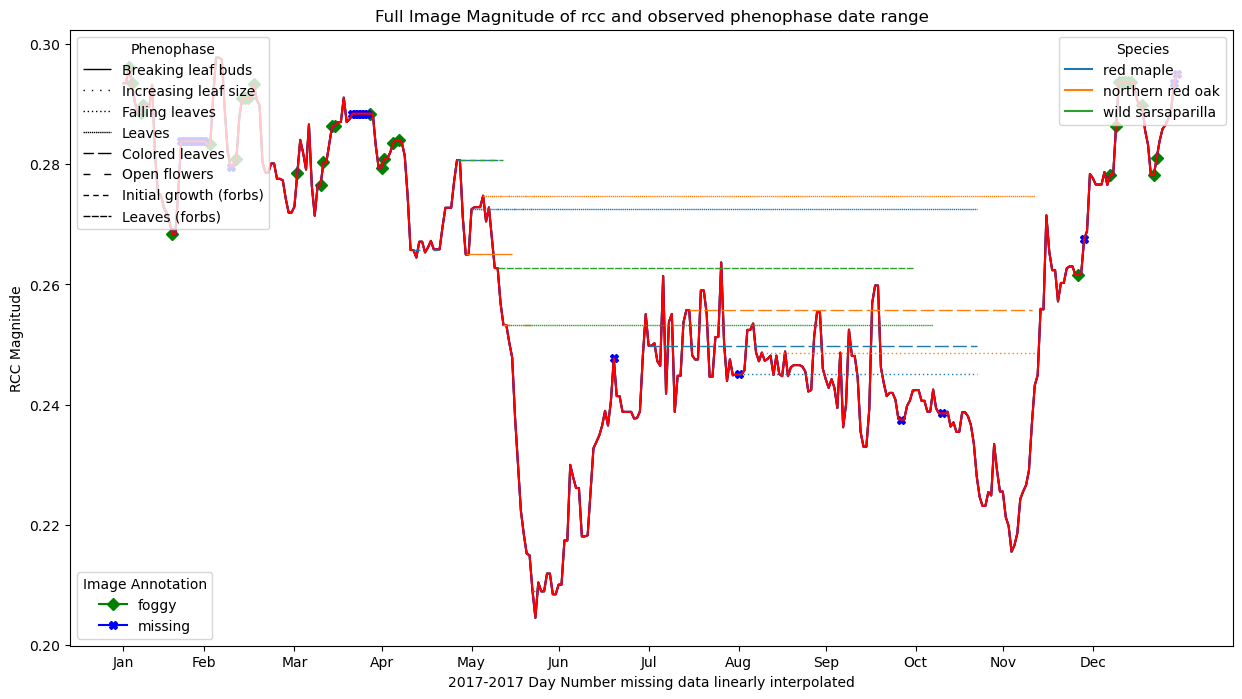

In [55]:
plot_xcc_vs_human_data(interpolated_xcc_original, "rcc")

[(371, 'Breaking leaf buds', (0, ()), 1), (467, 'Increasing leaf size', (0, (1, 5)), 1), (471, 'Falling leaves', (0, (1, 2)), 1), (483, 'Leaves', (0, (1, 0.5)), 1), (498, 'Colored leaves', (2.5, (10, 3)), 1), (501, 'Open flowers', (0, (5, 10)), 1), (482, 'Initial growth (forbs)', (0, (4, 3)), 1), (488, 'Leaves (forbs)', (0, (5, 1)), 1)]


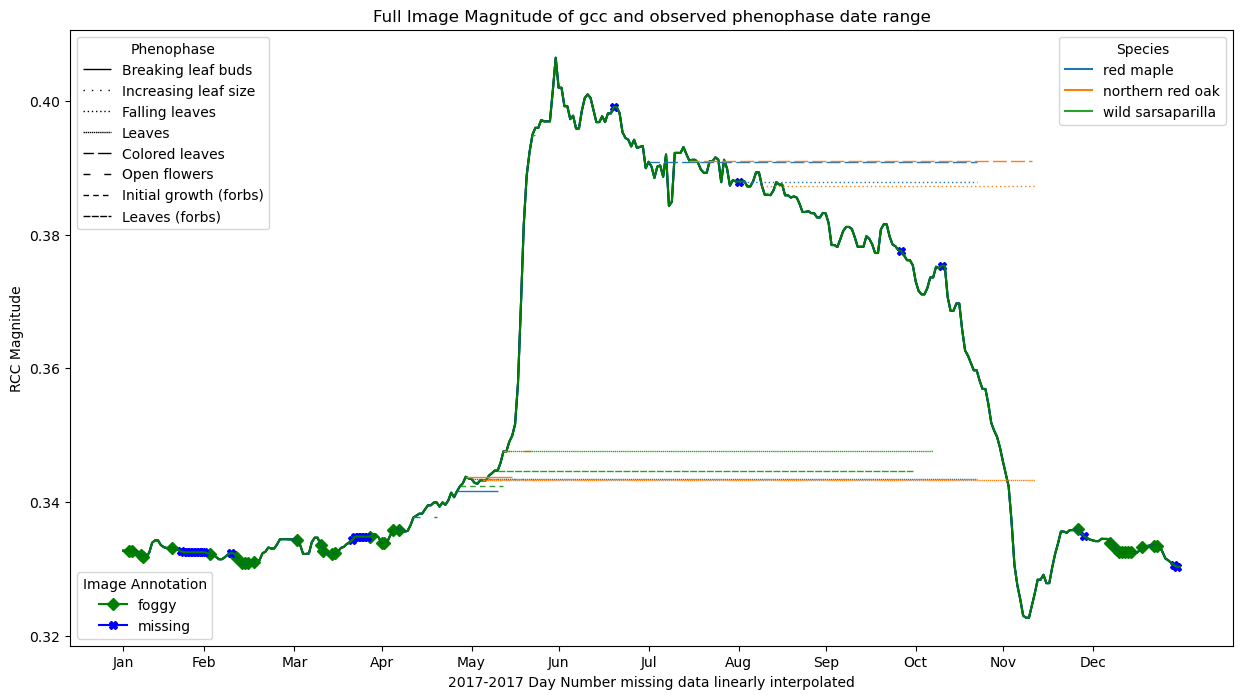

In [56]:
plot_xcc_vs_human_data(interpolated_xcc_original, "gcc")

In [ ]:

"""
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# This module reads USA-NPN Site phenometrics files for a given year and extracts the names
# of tree species that were observed that year.
# Colors are assigned to each species based on a prior color list.

# Read the CSV file into a Pandas DataFrame
NPNFile = '../data_raw/NPNNEON.D01.HARV.DP1.000332017-2023datasheet_1685753626088/site_phenometrics_dataHARV2017-2023.csv'
NPNdf = pd.read_csv(NPNFile)

# Create a dictionary to store the unique species_IDs along with their paired Common_Names
filtered_data = NPNdf[NPNdf['Mean_First_Yes_Year'] == 2017]

species_dict = {}

# Iterate through the DataFrame to populate the dictionary
for index, row in filtered_data.iterrows():
    species_id = row['Species_ID']
    common_name = row['Common_Name']
    species_dict[species_id] = common_name
unique_species_list = list(species_dict.items())
cmap = cm.get_cmap('tab10') # Use a color map for getting colors
SpeciesList = [] # Create a new list with the merged colors

for i, (species_id, species_name) in enumerate(unique_species_list):
    # Get the color from the color map based on the index 'i'
    color = cmap(i)
    SpeciesList.append((species_id, species_name, color))
#print (SpeciesList)

# Merge PhenophaseList and linestyles into one two-dimensional list
# Phenophase codes of interest
phenophase_dict = {}

# Iterate through the DataFrame to populate the dictionary
for index, row in filtered_data.iterrows():
    phenophase_id = row['Phenophase_ID']
    phenophase_description = row['Phenophase_Description']
    phenophase_dict[phenophase_id] = phenophase_description
unique_phenophase_list = list(phenophase_dict.items())


linestyle_tuple = [
    ('solid',        (0, ()),              1),
    ('loosely dotted',        (0, (1, 5)),  1),
    ('dotted',                (0, (1, 2)),   1),
    ('densely dotted',        (0, (1, .5)),  1),
    ('long dash with offset', (2.5, (10, 3)),  1),
    ('loosely dashed',        (0, (5, 10)),  1),
    ('dashed',                (0, (4, 3)),   1),
    ('densely dashed',        (0, (5, 1)),   1),
    ('loosely dashdotted',    (0, (3, 10, 1, 10)), 1),
    ('dashdotted',            (0, (3, 5, 1, 5)),    1),
    ('densely dashdotted',    (0, (3, 1, 1, 1)),    1),
    ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5)), 1),
    ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10)), 1),
    ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)), 1),
    ('thick solid',        (0, ()),              3),
    ('thick loosely dotted',        (0, (1, 10)),  3),
    ('thick dotted',                (0, (1, 1)),   3),
    ('thick densely dotted',        (0, (1, .5)),  3),
    ('thick long dash with offset', (5, (10, 3)),  3),
    ('thick loosely dashed',        (0, (5, 10)),  3),
    ('thick dashed',                (0, (4, 3)),   3),
    ('thick densely dashed',        (0, (5, 1)),   3),
    ('thick loosely dashdotted',    (0, (3, 10, 1, 10)), 3),
    ('thick dashdotted',            (0, (3, 5, 1, 5)),    3),
    ('thick densely dashdotted',    (0, (3, 1, 1, 1)),    3),
    ('thick dashdotdotted',         (0, (3, 5, 1, 5, 1, 5)), 3),
    ('thick loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10)), 3),
    ('thick densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)), 3)
]
# Convert the list of tuples to a list of dictionaries with line styles as keys
linestyles = [{ 'linestyle': style, 'dash_pattern': dash, 'linewidth': width } 
              for style, dash, width in linestyle_tuple]

PhenophaseList = [] # Create a new list with the merged colors
for i, (phenophase_id, phenophase_description) in enumerate(unique_phenophase_list):
    linestyle = linestyles[i]['linestyle']
    dash_pattern = linestyles[i]['dash_pattern']
    linewidth = linestyles[i]['linewidth']
    PhenophaseList.append((phenophase_id, phenophase_description, dash_pattern, linewidth))
print(PhenophaseList)
smoothed_xcc_original = xcc_median5_smooth(interpolated_xcc_original)

rcc = [data[0][0] for data in smoothed_xcc_original]
rcc_caption = str(years[0]) + "-" + years[-1] + " Day Number missing data linearly interpolated"
#xcc_title = "Filter#" + str(current_cluster) +  " Magnitude of rcc, gcc, and bcc"
rcc_title = "Full Image Magnitude of rcc and observed phenophase date range"
x = range(len(rcc))

#get foggy point and not available point
foggy_points = [data[1] for data in smoothed_xcc_original]
missing_points = [data[2] for data in smoothed_xcc_original]

Mean_First_Yes_Year  = 'Mean_First_Yes_Year'
# we might consider using , mean or median
PhenophaseStartDateColName = 'Mean_First_Yes_DOY'
PhenophaseEndDateColName = 'Mean_Last_Yes_DOY'
# Plot the lines
# there could be a larger outter loop for years 
Obsyear = 2017
# Obsyear = 2021
# Generate x-axis values and tick labels for the first day of each month
x_values = []
x_tick_positions = []
x_tick_labels = []
is_leap_year = calendar.isleap(Obsyear)
num_days_in_february = 29 if is_leap_year else 28
    
for month in range(1, 13):
    num_days_in_month = calendar.monthrange(Obsyear, month)[1]
        
    if month == 1:
        x_values.append(0)
        x_tick_positions.append(len(x_values) - 1)
        x_tick_labels.append(calendar.month_abbr[month])
    else:
        x_values.append(x_values[-1] + num_days_in_month)
        x_tick_positions.append(len(x_values) - 1)
        x_tick_labels.append(calendar.month_abbr[month])
        
    if month == 2:
        x_values[-1] += (num_days_in_february - num_days_in_month)

plt.figure(figsize = (15, 8))

plt.plot(x, rcc, '-gD', markevery=foggy_points, label='foggy')
plt.plot(x, rcc, '-bX', markevery=missing_points, label='missing')
plt.plot(x, rcc, color='red', label='rcc')

# Add a legend for phenophase and species
phenophase_handles = []
phenophase_labels = []

for _, phenophase, linestyle, linewidth in PhenophaseList:
    line, = plt.plot([], [], linestyle=linestyle, linewidth=linewidth, color='black')
    phenophase_handles.append(line)
    phenophase_labels.append(phenophase)

#since only one legend is managesd at a time it is nexessary to place one manually
PhenoLegend = plt.legend(phenophase_handles, phenophase_labels, loc='upper left', title='Phenophase')
ax = plt.gca().add_artist(PhenoLegend)

# Create legend for species with colored lines
species_handles = []
species_labels = []

for  _, species, color in SpeciesList:
    line, = plt.plot([], [], color=color)
    species_handles.append(line)
    species_labels.append(species)

plt.legend(species_handles, species_labels, loc='upper right', title='Species')

for speciesID, speciesname, SpeciesColor in SpeciesList:
    #print( speciesname, speciesID, SpeciesColor )
    for  PhenoCode, PhenoName, PhenoLineStyle, linewidth in PhenophaseList:
        #print('PhenoName, PhenoCode, PhenoLineStyle, linewidth ' 
        #      + PhenoName, PhenoCode, PhenoLineStyle, linewidth)
        selected_rows = NPNdf[(NPNdf['Species_ID'] == speciesID)
                & (NPNdf[Mean_First_Yes_Year] == Obsyear) 
                   & (NPNdf['Phenophase_ID'] == PhenoCode)]
        #print (selected_rows)
        if selected_rows.empty == False:
            PhenoStartDOY = list(selected_rows[PhenophaseStartDateColName])
            PhenoEndDOY = list(selected_rows[PhenophaseEndDateColName])
            # if end is before start then it rolled to the next year. reset to 365
            if PhenoStartDOY > PhenoEndDOY: PhenoEndDOY = 365
            #print("start stop", [PhenoStartDOY[0], PhenoEndDOY[0]], 
            #      [rcc[PhenoStartDOY[0]], rcc[PhenoStartDOY[0]]], color=SpeciesColor, 
            #      linestyle=PhenoLineStyle, linewidth=linewidth, label='Flowering')
            plt.plot([PhenoStartDOY[0], PhenoEndDOY[0]], 
                     [rcc[PhenoStartDOY[0]], rcc[PhenoStartDOY[0]]], color=SpeciesColor, 
                     linestyle=PhenoLineStyle, linewidth=linewidth, label=PhenoName)

# Set x-axis tick positions and labels
plt.xticks(x_values, x_tick_labels)


# Set the axis labels and title
plt.xlabel(rcc_caption)
plt.ylabel('RCC Magnitude')
plt.title(rcc_title)

# Display the plot
plt.show()"""

In [ ]:

"""
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# This module reads USA-NPN Site phenometrics files for a given year and extracts the names
# of tree species that were observed that year.
# Colors are assigned to each species based on a prior color list.

# Read the CSV file into a Pandas DataFrame
NPNFile = '../data_raw/NPNNEON.D01.HARV.DP1.000332017-2023datasheet_1685753626088/site_phenometrics_dataHARV2017-2023.csv'
NPNdf = pd.read_csv(NPNFile)

# Create a dictionary to store the unique species_IDs along with their paired Common_Names
filtered_data = NPNdf[NPNdf['Mean_First_Yes_Year'] == 2017]

species_dict = {}

# Iterate through the DataFrame to populate the dictionary
for index, row in filtered_data.iterrows():
    species_id = row['Species_ID']
    common_name = row['Common_Name']
    species_dict[species_id] = common_name
unique_species_list = list(species_dict.items())
cmap = cm.get_cmap('tab10') # Use a color map for getting colors
SpeciesList = [] # Create a new list with the merged colors

for i, (species_id, species_name) in enumerate(unique_species_list):
    # Get the color from the color map based on the index 'i'
    color = cmap(i)
    SpeciesList.append((species_id, species_name, color))
#print (SpeciesList)

# Merge PhenophaseList and linestyles into one two-dimensional list
# Phenophase codes of interest
phenophase_dict = {}

# Iterate through the DataFrame to populate the dictionary
for index, row in filtered_data.iterrows():
    phenophase_id = row['Phenophase_ID']
    phenophase_description = row['Phenophase_Description']
    phenophase_dict[phenophase_id] = phenophase_description
unique_phenophase_list = list(phenophase_dict.items())


linestyle_tuple = [
    ('solid',        (0, ()),              1),
    ('loosely dotted',        (0, (1, 5)),  1),
    ('dotted',                (0, (1, 2)),   1),
    ('densely dotted',        (0, (1, .5)),  1),
    ('long dash with offset', (2.5, (10, 3)),  1),
    ('loosely dashed',        (0, (5, 10)),  1),
    ('dashed',                (0, (4, 3)),   1),
    ('densely dashed',        (0, (5, 1)),   1),
    ('loosely dashdotted',    (0, (3, 10, 1, 10)), 1),
    ('dashdotted',            (0, (3, 5, 1, 5)),    1),
    ('densely dashdotted',    (0, (3, 1, 1, 1)),    1),
    ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5)), 1),
    ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10)), 1),
    ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)), 1),
    ('thick solid',        (0, ()),              3),
    ('thick loosely dotted',        (0, (1, 10)),  3),
    ('thick dotted',                (0, (1, 1)),   3),
    ('thick densely dotted',        (0, (1, .5)),  3),
    ('thick long dash with offset', (5, (10, 3)),  3),
    ('thick loosely dashed',        (0, (5, 10)),  3),
    ('thick dashed',                (0, (4, 3)),   3),
    ('thick densely dashed',        (0, (5, 1)),   3),
    ('thick loosely dashdotted',    (0, (3, 10, 1, 10)), 3),
    ('thick dashdotted',            (0, (3, 5, 1, 5)),    3),
    ('thick densely dashdotted',    (0, (3, 1, 1, 1)),    3),
    ('thick dashdotdotted',         (0, (3, 5, 1, 5, 1, 5)), 3),
    ('thick loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10)), 3),
    ('thick densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)), 3)
]
# Convert the list of tuples to a list of dictionaries with line styles as keys
linestyles = [{ 'linestyle': style, 'dash_pattern': dash, 'linewidth': width } 
              for style, dash, width in linestyle_tuple]

PhenophaseList = [] # Create a new list with the merged colors
for i, (phenophase_id, phenophase_description) in enumerate(unique_phenophase_list):
    linestyle = linestyles[i]['linestyle']
    dash_pattern = linestyles[i]['dash_pattern']
    linewidth = linestyles[i]['linewidth']
    PhenophaseList.append((phenophase_id, phenophase_description, dash_pattern, linewidth))
print(PhenophaseList)
smoothed_xcc_original = xcc_median5_smooth(interpolated_xcc_original)

gcc = [data[0][1] for data in smoothed_xcc_original]
gcc_caption = str(years[0]) + "-" + years[-1] + " Day Number missing data linearly interpolated"
#xcc_title = "Filter#" + str(current_cluster) +  " Magnitude of rcc, gcc, and bcc"
gcc_title = "Full Image Magnitude of gcc and observed phenophase date range"
x = range(len(gcc))

#get foggy point and not available point
foggy_points = [data[1] for data in smoothed_xcc_original]
missing_points = [data[2] for data in smoothed_xcc_original]

Mean_First_Yes_Year  = 'Mean_First_Yes_Year'
# we might consider using , mean or median
PhenophaseStartDateColName = 'Mean_First_Yes_DOY'
PhenophaseEndDateColName = 'Mean_Last_Yes_DOY'
# Plot the lines
# there could be a larger outter loop for years 
Obsyear = 2017
# Obsyear = 2021
# Generate x-axis values and tick labels for the first day of each month
x_values = []
x_tick_positions = []
x_tick_labels = []
is_leap_year = calendar.isleap(Obsyear)
num_days_in_february = 29 if is_leap_year else 28
    
for month in range(1, 13):
    num_days_in_month = calendar.monthrange(Obsyear, month)[1]
        
    if month == 1:
        x_values.append(0)
        x_tick_positions.append(len(x_values) - 1)
        x_tick_labels.append(calendar.month_abbr[month])
    else:
        x_values.append(x_values[-1] + num_days_in_month)
        x_tick_positions.append(len(x_values) - 1)
        x_tick_labels.append(calendar.month_abbr[month])
        
    if month == 2:
        x_values[-1] += (num_days_in_february - num_days_in_month)

plt.figure(figsize = (15, 8))

plt.plot(x, gcc, '-gD', markevery=foggy_points, label='foggy')
plt.plot(x, gcc, '-bX', markevery=missing_points, label='missing')

plt.plot(x, gcc, color='green', label='gcc')

# Add a legend for phenophase and species
phenophase_handles = []
phenophase_labels = []

for _, phenophase, linestyle, linewidth in PhenophaseList:
    line, = plt.plot([], [], linestyle=linestyle, linewidth=linewidth, color='black')
    phenophase_handles.append(line)
    phenophase_labels.append(phenophase)

#since only one legend is managesd at a time it is nexessary to place one manually
PhenoLegend = plt.legend(phenophase_handles, phenophase_labels, loc='upper left', title='Phenophase')
ax = plt.gca().add_artist(PhenoLegend)

# Create legend for species with colored lines
species_handles = []
species_labels = []

for  _, species, color in SpeciesList:
    line, = plt.plot([], [], color=color)
    species_handles.append(line)
    species_labels.append(species)

plt.legend(species_handles, species_labels, loc='upper right', title='Species')

for speciesID, speciesname, SpeciesColor in SpeciesList:
    #print( speciesname, speciesID, SpeciesColor )
    for  PhenoCode, PhenoName, PhenoLineStyle, linewidth in PhenophaseList:
        #print('PhenoName, PhenoCode, PhenoLineStyle, linewidth ' 
        #      + PhenoName, PhenoCode, PhenoLineStyle, linewidth)
        selected_rows = NPNdf[(NPNdf['Species_ID'] == speciesID)
                & (NPNdf[Mean_First_Yes_Year] == Obsyear) 
                   & (NPNdf['Phenophase_ID'] == PhenoCode)]
        #print (selected_rows)
        if selected_rows.empty == False:
            PhenoStartDOY = list(selected_rows[PhenophaseStartDateColName])
            PhenoEndDOY = list(selected_rows[PhenophaseEndDateColName])
            # if end is before start then it rolled to the next year. reset to 365
            if PhenoStartDOY > PhenoEndDOY: PhenoEndDOY = 365
            #print("start stop", [PhenoStartDOY[0], PhenoEndDOY[0]], 
            #      [rcc[PhenoStartDOY[0]], rcc[PhenoStartDOY[0]]], color=SpeciesColor, 
            #      linestyle=PhenoLineStyle, linewidth=linewidth, label='Flowering')
            plt.plot([PhenoStartDOY[0], PhenoEndDOY[0]], 
                     [gcc[PhenoStartDOY[0]], gcc[PhenoStartDOY[0]]], color=SpeciesColor, 
                     linestyle=PhenoLineStyle, linewidth=linewidth, label=PhenoName)

# Set x-axis tick positions and labels
plt.xticks(x_values, x_tick_labels)


# Set the axis labels and title
plt.xlabel(gcc_caption)
plt.ylabel('GCC Magnitude')
plt.title(gcc_title)

# Display the plot
plt.show()
"""

In [ ]:
print([m for m in missing_points if m])

In [ ]:

xcc_caption = str(years[0]) + "-" + years[-1] + " Day Number (some days may be skipped)"
smoothed_xcc_original = xcc_median5_smooth(interpolated_xcc_original)
plt.figure(figsize = (10, 8))
plot_xcc(xcc_median5_smooth(interpolated_xcc_original), "Full Image rcc, gcc, bcc", xcc_caption)
summer_image = plt.imread('../data_raw/NEON.D01.HARV.DP1.00033/2018/06/NEON.D01.HARV.DP1.00033_2018_06_30_120006.jpg')

DILATE = 1
for current_cluster in range (0, n_clusters):
#for current_cluster in ordered_center_color_index:
    masked_image = color_mask_image (Kmean_clustered_img, 
                        labels, 
                        [current_cluster], 
                        summer_image, DILATE)
    xcc_title = "Filter#" + str(current_cluster) +  "Diff from Original Magnitude of rcc, gcc, and bcc"
    xcc_diff = subtract_xcc (smoothed_xcc_original, xcc_median5_smooth(interpolated_xcc_cluster[current_cluster]))
    plt.figure(figsize = (10, 8))
    plot_xcc(xcc_diff, xcc_title, xcc_caption)
    plt.imshow(masked_image)


"""
smoothed_xcc_original = xcc_median5_smooth(interpolated_xcc_original)
plot_xcc(xcc_median5_smooth(smoothed_xcc_original), "Original Iimage rcc, gcc, bcc")
plot_xcc(interpolated_xcc_original, "Original Images rcc, gcc and bcc")
summer_image = plt.imread('../data_raw/NEON.D01.HARV.DP1.00033/2017/06/NEON.D01.HARV.DP1.00033_2017_06_30_120006.jpg')
DILATE = 1
for current_cluster in range (0, n_clusters):
    masked_image = color_mask_image (Kmean_clustered_img, 
                        labels, 
                        [ordered_center_color_index[current_cluster]], 
                        summer_image, DILATE)
    xcc_diff = subtract_xcc (smoothed_xcc_original, xcc_median5_smooth(interpolated_xcc_cluster[current_cluster]))
    print("cluster #:", current_cluster)
    plt.figure(figsize = (10, 8))
    plot_xcc(xcc_diff, "Difference between whole image and mask rcc, gcc, bcc")
    plt.imshow(masked_image)
"""


In [ ]:
new_list_1 = [item for item in xcc_over_time if item[-1] == 6]
new_list_2 = [item[0] for item in new_list_1]
plt.plot([row[RED] for row in new_list_2], color='red')
plt.plot([row[GREEN] for row in new_list_2], color='green')
plt.plot([row[BLUE] for row in new_list_2], color='blue')
plt.title("RCC comparison - with interpolated values")
plt.show()

#print (new_list_1)
#print (new_list_2)
#print(new_list_1[[][0]])

i = 1
for row in new_list_1:
    print(i, row)
    i = i + 1


In [ ]:
WINDOW_NAME = "win"
cv2.destroyWindow(WINDOW_NAME)
cv2.waitKey(1)
cv2.destroyWindow('Original image')
cv2.waitKey(1)

In [ ]:
# chatGPT code to expand a mask

# Load the image mask (assuming binary mask with clusters)
image_mask = cv2.imread('image_mask.png', 0)  # Read the mask as grayscale (0 = grayscale mode)

# Define the structuring element for dilation
kernel = np.ones((3, 3), np.uint8)  # Adjust the kernel size based on desired expansion

# Perform dilation to increase cluster size
expanded_mask = cv2.dilate(image_mask, kernel, iterations=1)

# Save the expanded mask
cv2.imwrite('expanded_mask.png', expanded_mask)
